## Data Augmentation

In [ ]:
# DATA AUGMENTATION

ind = random.randint(0,np.max(np.shape(df_ESC50)))
path1 = df_ESC50.full_path[ind]
#audio = librosa.load(path1, sr = 44100) #instead of this
audio = tfio.audio.AudioIOTensor(path1) #AudioIOTensor is lazy-loaded so only shape, dtype, and sample rate are shown initially.
audio = tf.squeeze(audio[:], axis=[-1])
print(f'Category: {df_ESC50.category[ind]}\n')
display(ipd.Audio(data = audio.numpy(), rate=sample_rate))

print('Cast the tensor to new type')
audio = tf.cast(audio, tf.float32) / 32768.0
plt.subplots(6, 1, figsize=(9, 15), squeeze = False)
plt.tight_layout(pad=3)
plt.subplot(6,1,1)
plt.plot(audio.numpy())

print('Use tfio.audio.trim')
position = tfio.audio.trim(audio, axis=0, epsilon=0.1) #Returns a tensor of start and stop with shape [..., 2, ...].
print(f'The positions are {position}')

start = position[0]
stop = position[1]
print(start, stop)

processed = audio[start:stop] #we cannot modify thew shape of our  input...discard this method

plt.subplot(6,1,2)
plt.plot(processed.numpy())


fade = tfio.audio.fade(audio, fade_in=100000, fade_out=200000, mode="logarithmic")

plt.subplot(6,1,3)
plt.plot(fade.numpy())
display(ipd.Audio(data = fade.numpy(), rate=sample_rate))

# Convert to spectrogram
spectrogram = tfio.audio.spectrogram( audio, nfft=512, window=512, stride=256)

plt.subplot(6,1,4)
plt.imshow(tf.math.log(spectrogram).numpy(), aspect = 'auto')

# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.subplot(6,1,5)
plt.imshow(tf.math.log(mel_spectrogram).numpy(), aspect = 'auto')

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

plt.subplot(6,1,6)
plt.imshow(dbscale_mel_spectrogram.numpy(),aspect = 'auto')

Here some methods for data augmentation.
Frequency and Time Masking discussed in SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019).


In [ ]:

plt.subplots(6, 1, figsize=(9, 15))
plt.tight_layout(pad=3)
for i in range(3):
    # Freq masking
    freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=20)

    plt.subplot(6,1,2*i+1)
    plt.title(f'freq mask number {i+1}')
    plt.imshow(freq_mask.numpy(), aspect = 'auto')

    # Time masking
    time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=500)

    plt.subplot(6,1,2*i+2)
    plt.title(f'time mask number {i+2}')
    plt.imshow(time_mask.numpy(), aspect = 'auto')


In [ ]:
audio_resample = tfio.audio.resample(input = audio, rate_in = sample_rate , rate_out = 80000)
print(audio_resample.shape)

display(ipd.Audio(data = audio.numpy(), rate=sample_rate))
display(ipd.Audio(data = audio_resample.numpy(), rate=sample_rate))

plt.subplots(2, 1, figsize=(9, 5))
plt.tight_layout(pad=3)


plt.subplot(2,1,1)
plt.plot(audio.numpy())


plt.subplot(2,1,2)
plt.plot(audio_resample.numpy())

## Autoencoders


### Old code

#### Solved adjusting the kernel

In [ ]:
INPUT_DIM = (220500,1)
code_size = 32
strides = 64


encoder = tf.keras.Sequential()
encoder.add(layers.InputLayer(input_shape=INPUT_DIM))
encoder.add(layers.Conv1D(16, 128, strides=strides, activation='relu', padding='same'))
encoder.add(layers.Conv1D(16, 128, strides=strides, activation='relu', padding='same'))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(code_size, activation='relu'))

nodes = int(INPUT_DIM[0]/strides/strides*16)
decoder = tf.keras.Sequential()
decoder.add(layers.InputLayer(input_shape=(code_size,)))
decoder.add(layers.Dense(nodes, activation='relu'))
decoder.add(layers.Reshape((nodes, 1)))
decoder.add(layers.Conv1DTranspose(16, 128, strides=256, activation='relu', padding='same'))
decoder.add(layers.Conv1DTranspose(1, 85, strides=1, activation='linear', padding='valid'))

encoder.summary()
decoder.summary()

#compile the model

encoder, decoder = build_autoencoder(INPUT_DIM, code_size=code_size)
# working with the autoencoder
inp = tf.keras.Input(INPUT_DIM)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

#compile and fit
epochs = 1
autoencoder,history = compile_and_fit(autoencoder, train, val,

                                        epochs=epochs,
                                        loss = tf.keras.losses.MeanSquaredError(),
                                        metrics = ['mse'],
                                        verbose = 1)

plot_history(history)



#### Solved second time

148
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3444, 16)          2064      
                                                                 
 flatten_2 (Flatten)         (None, 55104)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1763360   
                                                                 
Total params: 1765424 (6.73 MB)
Trainable params: 1765424 (6.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 55104)             1818432   
                                                        

2023-07-25 17:58:20.479775: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype float
	 [[{{node Placeholder/_5}}]]
2023-07-25 17:58:20.479966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


469/469 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0127

2023-07-25 17:59:43.936629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype float
	 [[{{node Placeholder/_8}}]]
2023-07-25 17:59:43.936861: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


469/469 [==============================] - 101s 181ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0181 - val_mse: 0.0181


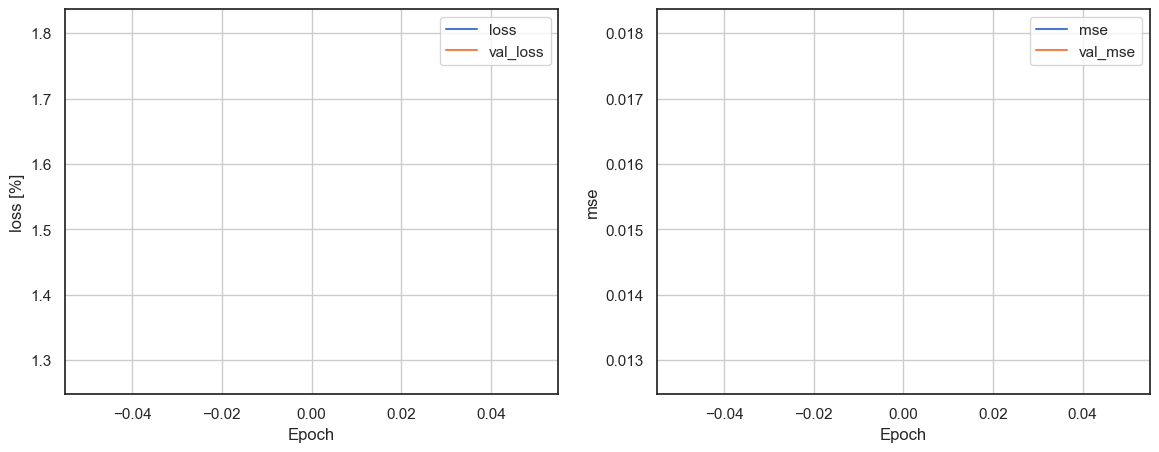

2023-07-25 18:00:01.727425: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype float
	 [[{{node Placeholder/_8}}]]
2023-07-25 18:00:01.727694: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


79/79 [==============================] - 17s 218ms/step - loss: 0.0183 - mse: 0.0183


{'loss': 0.01828565075993538, 'mse': 0.01828565075993538}

In [ ]:
import tensorflow as tf
from keras import layers
#INPUT_DIM = (220500,1)
code_size = 32
strides = 64
kernel_size = 128
n_filters = 16
kernel_size_T = INPUT_DIM[0]-strides*((INPUT_DIM[0]-kernel_size)//strides)
print(kernel_size_T)

def build_autoencoder(INPUT_DIM, code_size=code_size):
    encoder = tf.keras.Sequential()
    encoder.add(layers.InputLayer(input_shape=INPUT_DIM))
    encoder.add(layers.Conv1D(n_filters, kernel_size, strides=strides, activation='relu', padding='valid')) # output_shape = (1, (INPUT_DIM-kernel_size)//strides+1, n_filters)
    #encoder.add(layers.Conv1D(n_filters, kernel_size, strides=strides, activation='relu', padding='valid'))
    encoder.add(layers.Flatten())  # output_shape = (1, ((INPUT_DIM-kernel_size)//strides+1)* n_filters)
    encoder.add(layers.Dense(code_size, activation='relu'))

    r = ((INPUT_DIM[0]-kernel_size)//strides+1)* n_filters
    decoder = tf.keras.Sequential()
    decoder.add(layers.InputLayer(input_shape=(code_size,)))
    decoder.add(layers.Dense(r, activation='relu'))
    decoder.add(layers.Reshape((((INPUT_DIM[0]-kernel_size)//strides+1), n_filters)))
    #decoder.add(layers.Conv1DTranspose(n_filters, kernel_size, strides=256, activation='relu', padding='valid'))
    decoder.add(layers.Conv1DTranspose(1, kernel_size_T, strides=strides, activation='linear', padding='valid')) # output_shape = (1,strides*(input_shape-1)+kernel_size_T, 1 )

    return encoder, decoder

'''
import numpy as np
INPUT_DIM = 220500
strides =99
kernel_size = 345
n_filters = 16
print(layers.Conv1D(n_filters, kernel_size, strides=strides, activation='relu', padding='valid')(np.random.random((1, INPUT_DIM, 1))).shape)
output_shape = (1, (INPUT_DIM-kernel_size)//strides+1, n_filters)
print(output_shape)

input_shape = 22222
strides = 72
kernel_size = 2344
n_filters = 16
print(layers.Conv1DTranspose(n_filters, kernel_size, strides=strides, activation='relu', padding='valid')(np.random.random((1, input_shape , 1))).shape)
output_shape = (1,strides*(input_shape-1)+kernel_size,n_filters)
print(output_shape)
'''

#compile the model

encoder, decoder = build_autoencoder(INPUT_DIM, code_size=code_size)
encoder.summary()
decoder.summary()
# working with the autoencoder
inp = tf.keras.Input(INPUT_DIM)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

#compile and fit
epochs = 1
autoencoder,history = compile_and_fit(autoencoder, train, val,

                                        epochs=epochs,
                                        loss = tf.keras.losses.MeanSquaredError(),

                                        metrics = ['mse'],

                                        verbose = 1)

plot_history(history)

#evaluate the model

display(autoencoder.evaluate(test, return_dict=True))



#### 2nd Model

In [ ]:
def build_autoencoder(INPUT_DIM,code_size,strides = 64, dropout=0.2):
    encoder = tf.keras.Sequential()
    encoder.add(layers.InputLayer(input_shape=INPUT_DIM))
    encoder.add(layers.Conv1D(64, 128, strides=strides, activation='relu', padding='same'))
    if dropout is not None:
        encoder.add(layers.Dropout(dropout))
    encoder.add(layers.Conv1D(64, 128, strides=strides, activation='relu', padding='same'))
    if dropout is not None:
        encoder.add(layers.Dropout(dropout))
    encoder.add(layers.Conv1D(32, 128, strides=strides, activation='relu', padding='same'))
    encoder.add(layers.Flatten())
    if dropout is not None:
        encoder.add(layers.Dropout(dropout))
    encoder.add(layers.Dense(code_size, activation='relu'))

    nodes = int(INPUT_DIM[0]/strides/strides*16)
    decoder = tf.keras.Sequential()
    decoder.add(layers.InputLayer(input_shape=(code_size,)))
    decoder.add(layers.Dense(nodes, activation='relu'))
    decoder.add(layers.Reshape((nodes, 1)))
    if dropout is not None:
        decoder.add(layers.Dropout(dropout))
    decoder.add(layers.Conv1DTranspose(16, 128, strides=256, activation='relu', padding='valid'))
    if dropout is not None:
        decoder.add(layers.Dropout(dropout))
    decoder.add(layers.Conv1DTranspose(8, 128, strides=256, activation='relu', padding='valid'))
    if dropout is not None:
        decoder.add(layers.Dropout(dropout))
    decoder.add(layers.Conv1DTranspose(1, 128, strides=1, activation='linear', padding='valid'))
    desired_output_shape = (1, 220500, 1)
    output_cutter = OutputCutterLayer(desired_shape=desired_output_shape)
    decoder.add(output_cutter)
    if dropout is not None:
        decoder.add(layers.Dropout(dropout))

    return encoder, decoder

In [ ]:
#compile the model
code_size = 32
encoder, decoder = build_autoencoder(INPUT_DIM, code_size=code_size)

encoder.summary()
decoder.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 3446, 64)          8256      
                                                                 
 dropout_36 (Dropout)        (None, 3446, 64)          0         
                                                                 
 conv1d_30 (Conv1D)          (None, 54, 64)            524352    
                                                                 
 dropout_37 (Dropout)        (None, 54, 64)            0         
                                                                 
 conv1d_31 (Conv1D)          (None, 1, 32)             262176    
                                                                 
 flatten_9 (Flatten)         (None, 32)                0         
                                                                 
 dropout_38 (Dropout)        (None, 32)              

#### Other possible loss functions

In [ ]:
#interesting loss function fro images
def ssim_loss(y_true, y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(-1 * loss_rec)

# Load pre-trained VGG model with custom input shape
def create_vgg_model(input_shape=(None, None, 1)):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Remove the fully connected layers to make it a feature extraction model
    vgg_model = tf.keras.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block4_conv3').output)

    # Freeze the model's layers to prevent updating during training
    vgg_model.trainable = False

    return vgg_model

# Assuming your input images have shape (height, width, 1)
input_shape = (INPUT_DIM[0],INPUT_DIM[1], 1)

# Create the custom VGG model
vgg_model = create_vgg_model(input_shape)

# Function to compute perceptual loss using mean squared error
def perceptual_loss(y_true, y_pred):
    true_features = vgg_model(y_true)
    pred_features = vgg_model(y_pred)
    return tf.keras.losses.MeanSquaredError()(true_features, pred_features)


vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(INPUT_DIM[0], INPUT_DIM[1], 3))
vgg_model.trainable = False

def perceptual_loss(y_true, y_pred):
    def channel_3(a):
        return tf.convert_to_tensor([a,a,a]).transpose(axes = (1,2,3,0))
    true_features = vgg_model(channel_3(y_true))
    pred_features = vgg_model(channel_3(y_pred))
    #print the shapes
    print(f'The shape of the true features is {true_features.shape}')
    print(f'The shape of the predicted features is {pred_features.shape}')

    return tf.keras.losses.MeanSquaredError()(true_features, pred_features)



NameError: name 'INPUT_DIM' is not defined

In [ ]:
path_enc = os.path.join(main_dir,'Save_models', 'encoder.keras')
encoder.save(path_enc, save_format='keras')

### Other autoencoder trials with attempt to use the encoder for classification

Audio shape: (30, 64, 128, 1)
train batch type: <class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 0s 52ms/step
Encoded vector: [ -19.498005    34.571102   -75.83197    -73.64907    -42.1755
   59.032555    48.497303   -15.78361    -46.37464     29.034737
  -39.566723   -57.774746    19.78306    -59.4313     -20.343828
   39.613037  -170.1082     -90.73385      7.550675   154.296
    2.0458667  -44.653755    71.8785      17.586393   -66.52841
   -3.0090535   25.20467    -37.238148    26.728617   -90.08832
  -28.138845    14.797874 ]
Dim of encoded vector: (32,)
helicopter
Audio shape: (30, 64, 128, 1)
train batch type: <class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 0s 25ms/step


2023-07-19 10:27:19.712151: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-07-19 10:27:19.712455: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]


Encoded vector: [ -20.304516     22.647703    -58.75566     -59.202217    -39.23383
   48.976227     41.560097    -10.976493    -38.197456     23.783825
  -34.2976      -45.2549       14.123556    -48.65681     -12.747056
   21.152403   -134.43752     -85.76749      18.734987    131.73874
    0.72679406  -39.0358       61.001194     11.740923    -48.204796
    6.0843964    41.402843    -24.546513     19.72481     -77.39186
  -22.635206     11.558085  ]
Dim of encoded vector: (32,)
helicopter


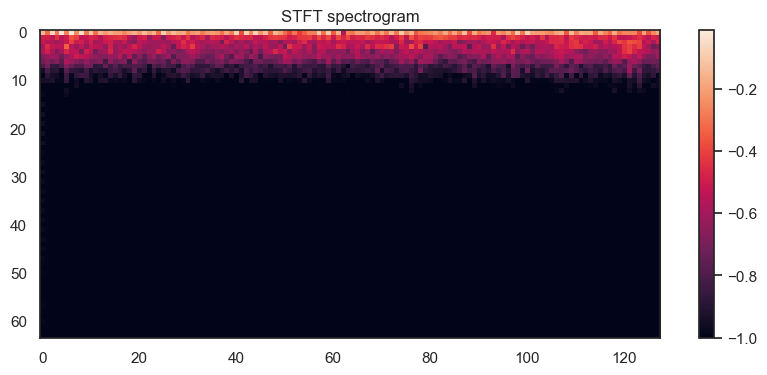

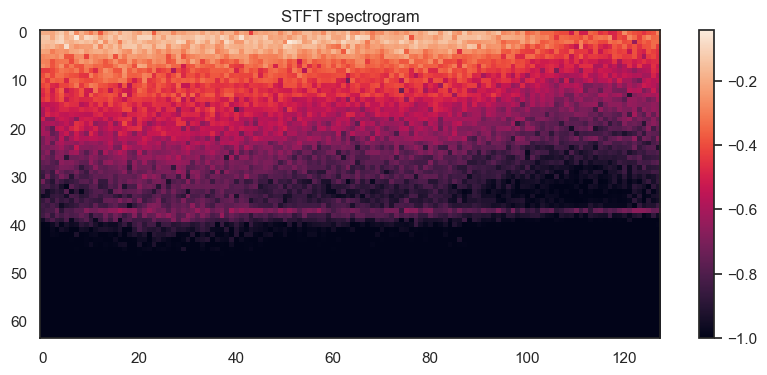

In [ ]:
#load the encoder
encoder_loaded = tf.keras.models.load_model(path_enc)

#show first element of the dataset
for example_train_batch, label in train.take(2):
    print(f'Audio shape: {example_train_batch.shape}')

    #print the types of object we have
    print(f'train batch type: {type(example_train_batch)}')

    #visualize the audio
    if len(example_train_batch[0].numpy().shape)<3:
        plt.figure(figsize=(10, 4))
        plt.plot(example_train_batch[0].numpy())
        plt.title(f'Audio plot')
        #listen to the audio
        display(ipd.Audio(data = np.reshape(example_train_batch[0].numpy(), [-1]), rate=samplerate)  )
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(example_train_batch[0].numpy(), aspect = 'auto')
        plt.colorbar()
        plt.title(f'{preprocessing} spectrogram')

    #predict the encoded vector
    y_pred = encoder_loaded.predict(example_train_batch)

    #show the encoded vector
    print(f'Encoded vector: {y_pred[0]}')
    print(f'Dim of encoded vector: {y_pred[0].shape}')
    print(label_names[np.argmax(label[0])])

# in train, val and test map the tuple (y,lab) to (y_pred,lab) where y_pred is the encoded vector and lab is the label creating new datasets
train_pred_labelled = train.map(lambda y,lab: (encoder_loaded(y),lab))
val_pred_labelled = val.map(lambda y,lab: (encoder_loaded(y),lab))
test_pred_labelled = test.map(lambda y,lab: (encoder_loaded(y),lab))




In [ ]:
#show the first element of train_labelled
for example_train_batch, label in train_pred_labelled.take(1):
    print(f'Encoded shape (batch, encoding dim): {example_train_batch.shape}')
    print(f'Encoded vector: {example_train_batch[0]}')
    print(f'Dim of encoded vector: {example_train_batch[0].shape}')
    print(f'Label of the encoded vector: {label[0]}')
    print(f'Label of the encoded vector: {label_names[np.argmax(label[0])]}')



Encoded shape (batch, encoding dim): (30, 32)
Encoded vector: [ -16.772871    19.66961    -53.842384   -60.015697   -30.530403
   42.49401     35.963875   -10.08637    -35.20646     23.041794
  -34.396645   -50.123703    13.764822   -42.19699    -15.987801
   38.798855  -125.54948    -78.95423      8.963234   125.706055
   -8.46276    -33.512745    50.34206     11.731409   -55.10377
   -2.3199146   35.77103    -25.514353    19.488712   -73.9951
  -20.154526    13.195342 ]
Dim of encoded vector: (32,)
Label of the encoded vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Label of the encoded vector: helicopter


2023-07-19 10:27:20.128041: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_42' with dtype resource
	 [[{{node Placeholder/_42}}]]
2023-07-19 10:27:20.128433: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_42' with dtype resource
	 [[{{node Placeholder/_42}}]]


### Training a dense neural network

In [ ]:
ENCODING_DIM = 32
num_labels = 10

In [ ]:
def build_dense_nn(ENC_DIM, num_labels):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(ENC_DIM,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ])
    return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 64)                2112      
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dense_39 (Dense)            (None, 10)                650       
                                                                 
Total params: 6922 (27.04 KB)
Trainable params: 6922 (27.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50


2023-07-19 10:27:36.556611: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-07-19 10:27:36.557046: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 14.4148 - accuracy: 0.0900

2023-07-19 10:27:37.358653: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype resource
	 [[{{node Placeholder/_37}}]]
2023-07-19 10:27:37.358977: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype resource
	 [[{{node Placeholder/_36}}]]


10/10 [==============================] - 1s 108ms/step - loss: 14.4148 - accuracy: 0.0900 - val_loss: 7.1013 - val_accuracy: 0.1000
Epoch 2/50
10/10 [==============================] - 1s 73ms/step - loss: 5.7869 - accuracy: 0.0933 - val_loss: 3.6911 - val_accuracy: 0.1000
Epoch 3/50
10/10 [==============================] - 1s 73ms/step - loss: 3.1681 - accuracy: 0.1400 - val_loss: 2.9100 - val_accuracy: 0.1800
Epoch 4/50
10/10 [==============================] - 1s 73ms/step - loss: 2.6085 - accuracy: 0.1533 - val_loss: 2.3332 - val_accuracy: 0.2600
Epoch 5/50
10/10 [==============================] - 1s 73ms/step - loss: 2.2814 - accuracy: 0.1600 - val_loss: 2.1663 - val_accuracy: 0.2200
Epoch 6/50
10/10 [==============================] - 1s 73ms/step - loss: 2.2016 - accuracy: 0.2033 - val_loss: 2.0043 - val_accuracy: 0.3000
Epoch 7/50
10/10 [==============================] - 1s 73ms/step - loss: 2.1060 - accuracy: 0.2200 - val_loss: 1.8779 - val_accuracy: 0.3600
Epoch 8/50
10/10 [====

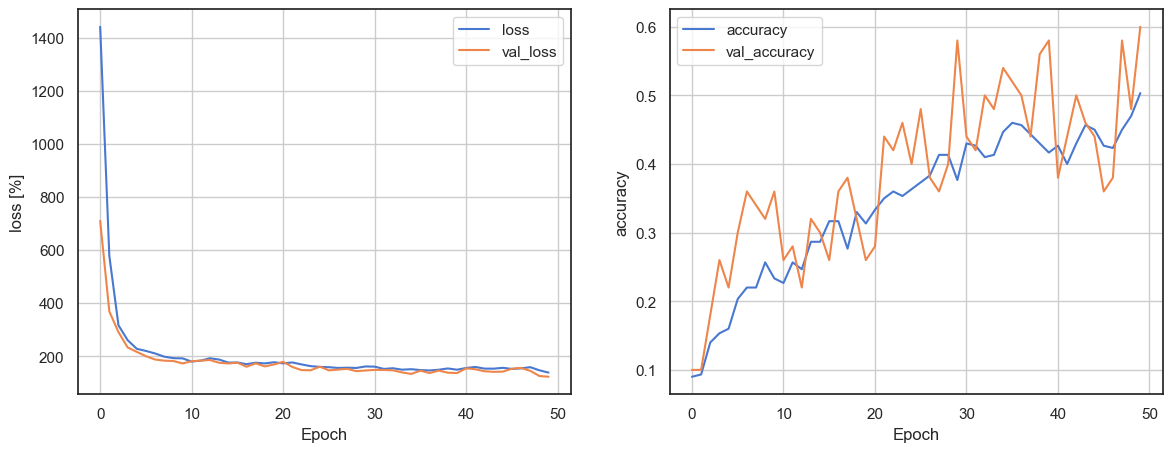

Evaluate on test data


2023-07-19 10:28:13.622370: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]
2023-07-19 10:28:13.622701: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]


2/2 [==============================] - 0s 82ms/step - loss: 1.2703 - accuracy: 0.6000


{'loss': 1.2702845335006714, 'accuracy': 0.6000000238418579}

In [ ]:
#build the model
model = build_dense_nn(ENCODING_DIM, num_labels)
model.summary()

#compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#fit the model
history = model.fit(train_pred_labelled, epochs=50, validation_data=val_pred_labelled, verbose=1)

#plot the history
plot_history(history)

#evaluate the model
print(f'Evaluate on test data')
display(model.evaluate(test_pred_labelled, return_dict=True))



### Training LSTM

In [ ]:
# exapand the dim of the encoded vector
train_pred_labelled_exp = train_pred_labelled.map(lambda y,lab: (tf.expand_dims(y, axis=-1),lab))
val_pred_labelled_exp = val_pred_labelled.map(lambda y,lab: (tf.expand_dims(y, axis=-1),lab))
test_pred_labelled_exp = test_pred_labelled.map(lambda y,lab: (tf.expand_dims(y, axis=-1),lab))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dense_45 (Dense)            (None, 10)                1290      
                                                                 
Total params: 67850 (265.04 KB)
Trainable params: 67850 (265.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 2s 88ms/step - loss: 2.3301 - accuracy: 0.0967 - val_loss: 2.2669 - val_accuracy: 0.2200
Epoch 2/500
10/10 [==============================] - 1s 76ms/step - loss: 2.2610 - accuracy: 0.2100 - val_loss: 2.2133 - val_accuracy: 0.3000
Epoch 3/500
10/10 [==============================] - 1s 73ms/step - loss: 2.2103 - accuracy: 0.1867 - val_loss: 2.1532 - val_ac

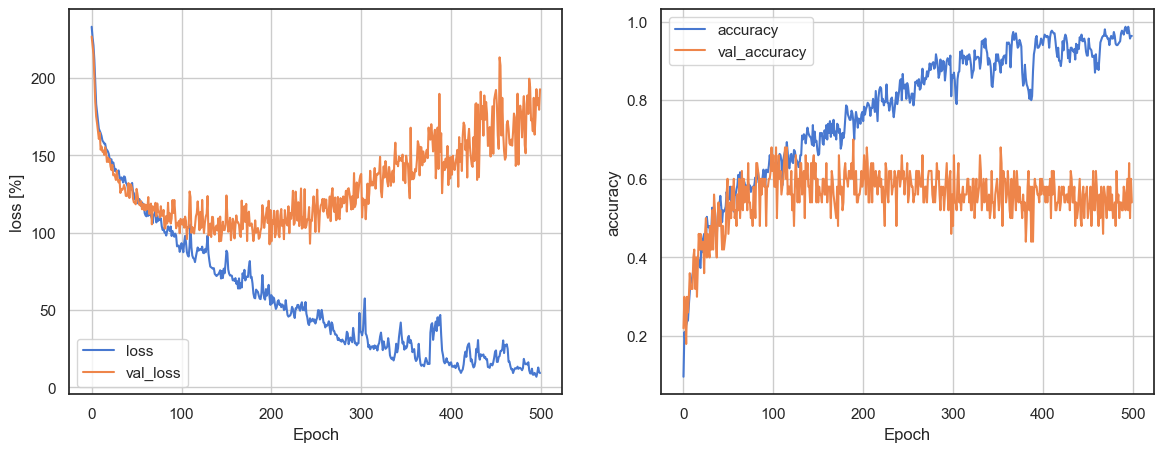

Evaluate on test data
2/2 [==============================] - 0s 38ms/step - loss: 1.8137 - accuracy: 0.6200


{'loss': 1.8136646747589111, 'accuracy': 0.6200000047683716}

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

random_seed = 42

# define model LSTM sequential over train_pred_labelled dataset

model_LSTM = Sequential()
model_LSTM.add(LSTM(128, activation = 'tanh', input_shape=( 32,1)))
model_LSTM.add(Dense(10, activation='softmax'))
model_LSTM.summary()

#compile the model

model_LSTM.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#fit the model
history = model_LSTM.fit(train_pred_labelled, epochs=500, validation_data=val_pred_labelled, verbose=1)

#plot the history
plot_history(history)

#evaluate the model
print(f'Evaluate on test data')
display(model_LSTM.evaluate(test_pred_labelled, return_dict=True))

### LSTM more elegant

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 32)                1067424   
                                                                 
 reshape_20 (Reshape)        (None, 32, 1)             0         
                                                                 
 lstm_27 (LSTM)              (None, 32, 128)           66560     
                                                                 
 dropout_5 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_28 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_68 (Dense)            (None, 10)              

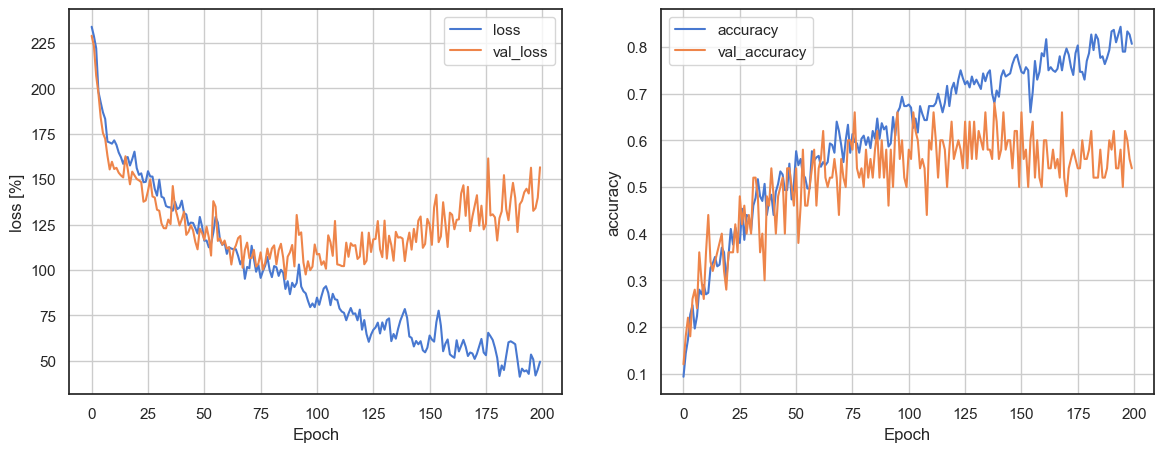

Evaluate on test data
2/2 [==============================] - 0s 45ms/step - loss: 1.4830 - accuracy: 0.6400


{'loss': 1.4830127954483032, 'accuracy': 0.6399999856948853}

In [ ]:
#define a unique model with encoding layer and LSTM layer
layer_encoding = encoder_loaded
layer_encoding.trainable = False
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    layer_encoding,
    tf.keras.layers.Reshape((32,1)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

# shape of input (30,64,128,1)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#fit the model
history = model.fit(train, epochs=200, validation_data=val, verbose=1)

#plot the history
plot_history(history)

#evaluate the model
print(f'Evaluate on test data')
display(model.evaluate(test, return_dict=True))

### Attention Pernini

In [ ]:
from tensorflow.keras import backend as K

def att_RNNmodel_var(input_shape):

    X_input = tf.keras.Input(input_shape)
    X_input = tf.keras.layers.Normalization()(X_input)

    tf.keras.regularizers.L1L2(l1=0.00000001, l2=0.0000001)

    x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(X_input)

    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l1_l2')
                        )(x)
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l1_l2')
                        )(x)

    xFirst = tf.keras.layers.Lambda(lambda q: q[:, -1])(x)
    query = tf.keras.layers.Dense(256)(xFirst)

    attScores = tf.keras.layers.Dot(axes=[1, 2])([query, x])
    attScores = tf.keras.layers.Softmax(name='attSoftmax')(attScores)

    attVector = tf.keras.layers.Dot(axes=[1, 1])([attScores, x])

    attVector = attVector[..., tf.newaxis]

    x = tf.keras.layers.Conv1D(10, 3, activation='relu', padding='same')(attVector)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(35, activation='softmax')(x)

    model = tf.keras.Model(inputs = X_input, outputs = x, name='StrangeModel')

    return model